In [3]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../src')
import warnings
warnings.filterwarnings('ignore')

from spaceoracle.prophets import Prophet

In [18]:
# adata_train = sc.read_h5ad(
#     '/ix/djishnu/shared/djishnu_kor11/training_data/slideseq_spleen.h5ad')

adata_train = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

pythia = Prophet(
    adata=adata_train,
    models_dir='/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/human_tonsil_v4',
    annot='cell_type_int',
    annot_labels='cell_type',
    species='human'
)

[]


In [9]:
genes = ['GATA3', 'PAX5', 'STAT1', 'STAT4']
set(genes) & set(adata_train.var_names)

{'GATA3', 'PAX5', 'STAT1', 'STAT4'}

In [ ]:
pythia.perturb_batch(
    target_genes=genes, 
    n_propagation=3, 
    gene_expr=0, 
    save_to='/ix/djishnu/shared/djishnu_kor11/perturbations/snrna_human_tonsil'
)

In [4]:
xy = pd.DataFrame(pythia.adata.obsm['spatial'], columns=['x', 'y'], index=pythia.adata.obs_names)


In [14]:
# plt.rcParams['figure.figsize'] = [6, 6]
# plt.rcParams['figure.dpi'] = 180

# sns.scatterplot(
#     data = xy.join(pythia.adata.obs),
#     x='x', y='y', 
#     hue='cell_type',
#     palette='tab20',
#     s=20
# )

# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.gca().set_xticklabels([])
# plt.gca().set_yticklabels([])
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.legend(bbox_to_anchor=(0.5, -0.1), 
#            loc='upper center', ncol=4, frameon=False)
# plt.xlabel('')
# plt.ylabel('')
# plt.show()


In [4]:
import commot as ct

from spaceoracle.tools.network import expand_paired_interactions
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)

In [5]:
lr = lr[lr.ligand.isin(pythia.adata.var_names) & lr.receptor.isin(pythia.adata.var_names)]

In [ ]:
pythia.queue

OracleQueue with 0 remaining genes

In [7]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl',
    organism='human',
    annot='cell_type_int'
)

In [ ]:
pythia.compute_betas()

100%|██████████| 3413/3413 [00:34<00:00, 98.47it/s] 


In [9]:
goi = 'IL7'

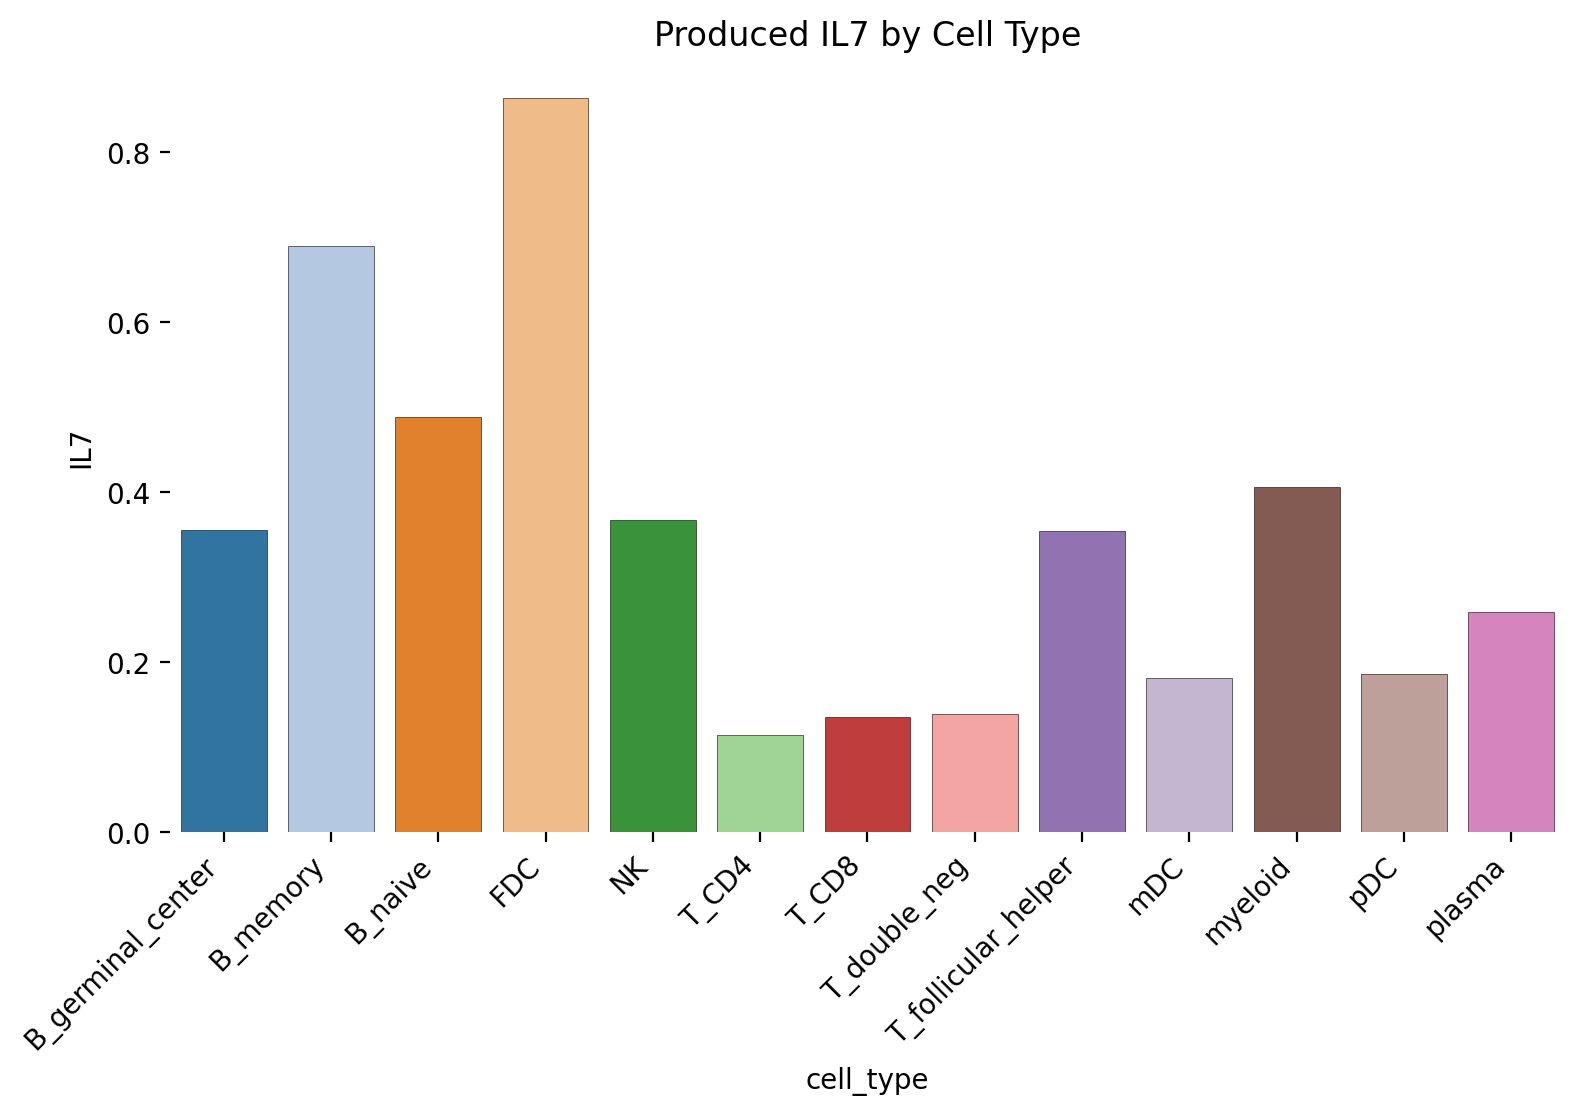

In [ ]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.dpi'] = 100

xy = pd.DataFrame(pythia.adata.obsm['spatial'], columns=['x', 'y'], index=pythia.adata.obs_names)
sns.barplot(
    data=pythia.adata.to_df(layer='imputed_count').join(xy).join(
        pythia.adata.obs['cell_type']).groupby(
            'cell_type')[goi].mean().reset_index(),
    x='cell_type',
    y=goi,
    linewidth=0.2,
    edgecolor='black',
    palette='tab20'
)
plt.xticks(rotation=45, ha='right')
plt.title(f'Produced {goi} by Cell Type')
plt.box(False)
plt.show()

In [ ]:
# cells = list(
#     pythia.adata.obs.reset_index()[
#         pythia.adata.obs.reset_index()['cell_type'].isin(
#             ['T_follicular_helper']
#         )].index)

cell_idx = xy[
    (xy.x > 2000) & (xy.y < 1500)].join(
    pythia.adata.obs['cell_type']).query('cell_type=="FDC"').index

cells = pythia.adata.obs.reset_index()[pythia.adata.obs.reset_index()['NAME'].isin(cell_idx)].index.tolist()

# cells = pythia.adata.obs.reset_index().index.tolist()
len(cells), len(adata_train.obs)

(34, 5778)

View of AnnData object with n_obs × n_vars = 34 × 3540
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

In [ ]:
# sns.scatterplot(
#     data=xy.join(pythia.adata[:, :].obs),
#     x='x', y='y', c='grey'
# )

# sns.scatterplot(
#     data=xy.join(pythia.adata[cells, :].obs),
#     x='x', y='y', hue='cell_type'
# )

In [21]:
goi

'IL7'

In [ ]:
pythia.perturb(
    target=goi, 
    n_propagation=3, 
    gene_expr=0, 
    cells=cells,
)

Running simulation 3/3: 100%|██████████| 5778/5778 [07:15<00:00, 13.28it/s]


In [ ]:
# plt.rcParams['figure.figsize'] = (8, 8)
# plt.rcParams['figure.dpi'] = 120

# s = 25
# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).query('cell_type!="FDC"'), 
#     s=s,
#     color='grey',
#     alpha=0.5,
#     legend=False,
#     label='Other Cells'
# )

# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).query('cell_type=="FDC"'), 
#     color='orange',
#     linewidth=0.2,
#     edgecolor='black',
#     s=s+15,
#     alpha=0.5, 
#     legend=False,
#     label='FDC Cells'
# )

# sns.scatterplot(
#     x='x', y='y', 
#     data=xy.join(pythia.adata.obs['cell_type']).iloc[cells], 
#     color='red',
#     marker='X',
#     s=s,
#     alpha=0.5, 
#     legend=False,
#     label='knockout targets'
# )
# plt.legend()
# plt.gca().set_axis_off()
# plt.show()

In [28]:
pythia.adata.to_df(layer='delta_X').mean().sort_values(ascending=False)

Unnamed: 0
EBF1      0.000626
H2AFZ     0.000281
FDCSP     0.000279
RHEX      0.000250
CLU       0.000246
            ...   
SKAP1    -0.000266
LHFPL2   -0.000279
CAMK4    -0.000281
FOXP1    -0.000290
IL7      -0.004836
Length: 3540, dtype: float64

In [ ]:
pythia.adata.obs = pythia.adata.obs.join(pd.read_csv('/tmp/banksy_celltypes.csv', index_col=0))

In [38]:
pythia.adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [77]:
color_dict = {
    'T_CD4': "#ea7465",
    'T_follicular_helper': "#b74329", 
    'T_CD8': "#dd3652",
    
    'GC Light Zone': "#5bbbdb",
    'GC Intermediate Zone': "#5bbbdb",
    'GC Dark Zone': "#5bbbdb",
    
    'B_memory': "#61c17c",
    'B_naive': "#4b9131", 
    'plasma': "#beb637",
    
    'mDC/myeloid': "#c6ccc2",
    'FDC': "#79949a",
    'pDC': "#98907f"
}

In [1]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['figure.dpi'] = 100

# Create the data first
plot_data = pythia.adata.to_df(layer='delta_X').join(xy).join(
    pythia.adata.obs['cell_type']).query('cell_type=="B_germinal_center"')
foxp1_values = plot_data['FOXP1']

# Create scatter plot
g = sns.scatterplot(
    data=plot_data,
    x='x', y='y',
    hue='FOXP1',
    palette='magma', 
    linewidth=0.2,
    legend=False,
    edgecolor='black',
    s=40
)

# Create colorbar using the actual data values
norm = plt.Normalize(foxp1_values.min(), foxp1_values.max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
plt.colorbar(sm, ax=g)

NameError: name 'plt' is not defined